In [1]:
import locale
from typing import List
import pandas as pd

import rangekeeper as rk

In [2]:
locale.setlocale(locale.LC_ALL, 'en_au')
units = rk.measure.Index.registry
currency = rk.measure.register_currency(registry=units)
params = {
    'start_date': pd.Timestamp('2001-01-01'),
    'num_periods': 10,
    'period_type': rk.periodicity.Type.YEAR,
    'acquisition_cost': -1000 * currency.units,
    'initial_income': 100 * currency.units,
    'growth_rate': 0.02,
    'vacancy_rate': 0.05,
    'opex_pgi_ratio': 0.35,
    'capex_pgi_ratio': 0.1,
    'exit_caprate': 0.05,
    'discount_rate': 0.07
    }

In [3]:
class BaseModel:
    def __init__(self) -> None:
        pass
    
    def set_params(self, params: dict) -> None:
        self.params = params

In [4]:
@rk.update_class(BaseModel)
class BaseModel:
    def init_spans(self):
        self.calc_span = rk.span.Span.from_num_periods(
            name='Span to Calculate Reversion',
            date=self.params['start_date'],
            period_type=self.params['period_type'],
            num_periods=self.params['num_periods'] + 1)
        self.acq_span = rk.span.Span.from_num_periods(
            name='Acquisition Span',
            date=rk.periodicity.offset_date(
                self.params['start_date'],
                num_periods=-1,
                period_type=self.params['period_type']),
            period_type=self.params['period_type'],
            num_periods=1)
        self.span = self.calc_span.shift(
            name='Span',
            num_periods=-1,
            period_type=self.params['period_type'],
            bound='end')
        self.reversion_span = self.span.shift(
            name='Reversion Span',
            num_periods=self.params['num_periods'] - 1,
            period_type=self.params['period_type'],
            bound='start')

In [5]:
@rk.update_class(BaseModel)
class BaseModel:
    def calc_acquisition(self):
        self.acquisition = rk.flux.Flow.from_projection(
            name='Acquisition',
            value=self.params['acquisition_cost'],
            proj=rk.projection.Distribution(
                form=rk.distribution.Uniform(),
                sequence=self.acq_span.to_index(period_type=self.params['period_type'])),
            units=currency.units)

    def calc_egi(self):
        self.pgi = rk.flux.Flow.from_projection(
            name='Potential Gross Income',
            value=self.params['initial_income'],
            proj=rk.projection.Extrapolation(
                form=rk.extrapolation.Compounding(
                    rate=self.params['growth_rate']),
                sequence=self.calc_span.to_index(period_type=self.params['period_type'])),
            units=currency.units)
        self.vacancy = rk.flux.Flow(
            name='Vacancy Allowance',
            movements=self.pgi.movements * -self.params['vacancy_rate'],
            units=currency.units)
        self.egi = rk.flux.Stream(
            name='Effective Gross Income',
            flows=[self.pgi, self.vacancy],
            period_type=self.params['period_type']).sum()

    def calc_noi(self):
        self.opex = rk.flux.Flow(
            name='Operating Expenses',
            movements=self.pgi.movements * self.params['opex_pgi_ratio'],
            units=currency.units).invert()
        self.noi = rk.flux.Stream(
            name='Net Operating Income',
            flows=[self.egi, self.opex],
            period_type=self.params['period_type']).sum()

    def calc_ncf(self):
        self.capex = rk.flux.Flow(
            name='Capital Expenditures',
            movements=self.pgi.movements * self.params['capex_pgi_ratio'],
            units=currency.units).invert()
        self.net_cf = rk.flux.Stream(
            name='Net Annual Cashflow',
            flows=[self.noi, self.capex],
            period_type=self.params['period_type']).sum()

    def calc_reversion(self):
        self.reversions = rk.flux.Flow(
            name='Reversions',
            movements=self.net_cf.movements.shift(periods=-1).dropna() /
                      self.params['exit_caprate'],
            units=currency.units).trim_to_span(span=self.span)
        self.reversion = self.reversions.trim_to_span(
            span=self.reversion_span,
            name='Reversion')

        self.pbtcfs = rk.flux.Stream(
            name='PBTCFs',
            flows=[
                self.net_cf.trim_to_span(span=self.span),
                self.reversions.trim_to_span(span=self.reversion_span)
                ],
            period_type=self.params['period_type'])

In [6]:
@rk.update_class(BaseModel)
class BaseModel:
    def calc_metrics(self):
        pvs = []
        irrs = []
        for period in self.net_cf.trim_to_span(span=self.span).movements.index:
            cumulative_net_cf = self.net_cf.trim_to_span(
                span=rk.span.Span(
                    name='Cumulative Net Cashflow Span',
                    start_date=self.params['start_date'],
                    end_date=period))
            reversion = rk.flux.Flow(
                movements=self.reversions.movements.loc[[period]],
                units=currency.units)
            cumulative_net_cf_with_rev = rk.flux.Stream(
                name='Net Cashflow with Reversion',
                flows=[
                    cumulative_net_cf,
                    reversion
                    ],
                period_type=self.params['period_type'])
            pv = cumulative_net_cf_with_rev.sum().pv(
                name='Present Value',
                period_type=self.params['period_type'],
                discount_rate=self.params['discount_rate'])
            pvs.append(pv.collapse().movements)

            incl_acq = rk.flux.Stream(
                name='Net Cashflow with Reversion and Acquisition',
                flows=[cumulative_net_cf_with_rev.sum(), self.acquisition],
                period_type=self.params['period_type'])

            irrs.append(round(incl_acq.sum().xirr(), 4))

        self.pvs = rk.flux.Flow(
            name='Present Values',
            movements=pd.concat(pvs),
            units=currency.units)
        self.irrs = rk.flux.Flow(
            name='Internal Rates of Return',
            movements=pd.Series(irrs, index=self.pvs.movements.index),
            units=None)

In [7]:
@rk.update_class(BaseModel)
class BaseModel:
    def generate(self):
        self.init_spans()
        self.calc_acquisition()
        self.calc_egi()
        self.calc_noi()
        self.calc_ncf()
        self.calc_reversion()
        self.calc_metrics()

In [8]:
ex_ante = BaseModel()
ex_ante.set_params(params)
ex_ante.generate()

In [9]:
ex_ante_table = rk.flux.Stream(
    name='Ex-Ante Pro-forma Cash Flow Projection',
    flows=[
        ex_ante.pgi,
        ex_ante.vacancy,
        ex_ante.egi,
        ex_ante.opex,
        ex_ante.noi,
        ex_ante.capex,
        ex_ante.net_cf,
        ex_ante.reversion,
        ],
    period_type=rk.periodicity.Type.YEAR
    )
ex_ante_table

date,Potential Gross Income,Vacancy Allowance,Effective Gross Income (sum),Operating Expenses,Net Operating Income (sum),Capital Expenditures,Net Annual Cashflow (sum),Reversion
2001,$100.00,-$5.00,$95.00,-$35.00,$60.00,-$10.00,$50.00,0
2002,$102.00,-$5.10,$96.90,-$35.70,$61.20,-$10.20,$51.00,0
2003,$104.04,-$5.20,$98.84,-$36.41,$62.42,-$10.40,$52.02,0
2004,$106.12,-$5.31,$100.81,-$37.14,$63.67,-$10.61,$53.06,0
2005,$108.24,-$5.41,$102.83,-$37.89,$64.95,-$10.82,$54.12,0
2006,$110.41,-$5.52,$104.89,-$38.64,$66.24,-$11.04,$55.20,0
2007,$112.62,-$5.63,$106.99,-$39.42,$67.57,-$11.26,$56.31,0
2008,$114.87,-$5.74,$109.13,-$40.20,$68.92,-$11.49,$57.43,0
2009,$117.17,-$5.86,$111.31,-$41.01,$70.30,-$11.72,$58.58,0
2010,$119.51,-$5.98,$113.53,-$41.83,$71.71,-$11.95,$59.75,"$1,218.99"


In [10]:
print('Projected IRR at Market Value Price: {:.2%}'.format(ex_ante.irrs.movements[-1]))
print('Time 0 Present Value at OCC: {0}'.format(locale.currency(ex_ante.pvs.movements[-1], grouping=True)))
print('Average Annual Cashflow: {0}'.format(locale.currency(ex_ante.net_cf.trim_to_span(ex_ante.span).movements.mean(), grouping=True)))

Projected IRR at Market Value Price: 7.00%
Time 0 Present Value at OCC: $1,000.00
Average Annual Cashflow: $54.75


In [11]:
period_type = rk.periodicity.Type.YEAR
num_periods = 25
span = rk.span.Span.from_num_periods(
    name="Span",
    date=pd.Timestamp(2000, 1, 1),
    period_type=period_type,
    num_periods=num_periods)
sequence = span.to_index(period_type=period_type)

In [12]:
trend = rk.dynamics.trend.Trend(
    sequence=sequence,
    cap_rate=.05,
    initial_value=0.050747414,
    growth_rate=-0.002537905)

In [13]:
volatility = rk.dynamics.volatility.Volatility(
    sequence=sequence,
    trend=trend,
    volatility_per_period=.1,
    autoregression_param=.2,
    mean_reversion_param=.3)

In [14]:
cyclicality = rk.dynamics.cyclicality.Cyclicality.from_estimates(
    space_cycle_phase_prop=0,
    space_cycle_period=13.8,
    space_cycle_height=1,
    space_cycle_asymmetric_parameter=.5,
    asset_cycle_period_diff=0.8,
    asset_cycle_phase_diff_prop=-.05,
    asset_cycle_amplitude=.02,
    asset_cycle_asymmetric_parameter=.5,
    sequence=sequence)

In [15]:
noise = rk.dynamics.noise.Noise(
    sequence=sequence,
    noise_dist=rk.distribution.Symmetric(
        type=rk.distribution.Type.TRIANGULAR,
        residual=.1))

black_swan = rk.dynamics.black_swan.BlackSwan(
    sequence=sequence,
    likelihood=.05,
    dissipation_rate=.3,
    probability=rk.distribution.Uniform(),
    impact=-.25)

In [16]:
market = rk.dynamics.market.Market(
    sequence=sequence,
    trend=trend,
    volatility=volatility,
    cyclicality=cyclicality,
    noise=noise,
    black_swan=black_swan)
table = rk.flux.Stream(
    name='Market Dynamics',
    flows=[
        market.trend,
        market.volatility.volatility,
        market.volatility.autoregressive_returns,
        market.volatility,
        market.cyclicality.space_waveform,
        market.space_market,
        market.cyclicality.asset_waveform,
        market.asset_market,
        market.asset_true_value,
        market.space_market_price_factors,
        market.noisy_value,
        market.historical_value,
        market.implied_rev_cap_rate,
        market.returns
        ],
    period_type=period_type)

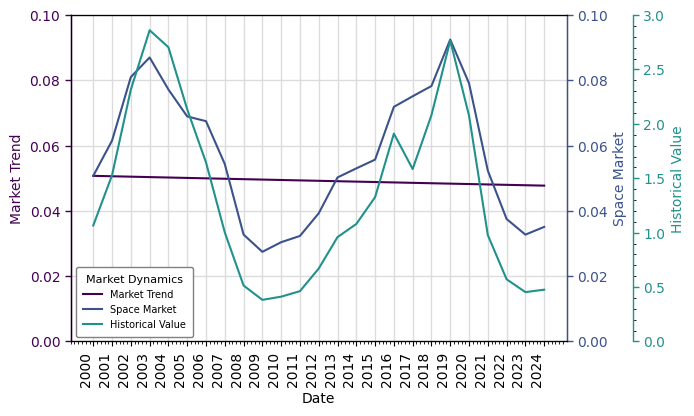

In [17]:
table.plot(
        flows={
            'Market Trend': (0, .1),
            'Space Market': (0, .1),
            'Historical Value': (0, 3)
            }
        )

In [18]:
class ExPostInflexModel(BaseModel):
    def set_market(self, market: rk.dynamics.market.Market) -> None:
        self.market = market

In [19]:
@rk.update_class(ExPostInflexModel)
class ExPostInflexModel(BaseModel):
    def calc_egi(self):
        pgi = rk.flux.Flow.from_projection(
            name='Potential Gross Income',
            value=self.params['initial_income'],
            proj=rk.projection.Extrapolation(
                form=rk.extrapolation.Compounding(
                    rate=self.params['growth_rate']),
                sequence=self.calc_span.to_index(period_type=self.params['period_type'])),
            units=currency.units)

        # Construct a Stream that multiplies the Base Model's PGI by the
        # simulated Market's Space Market factors
        self.pgi = rk.flux.Stream(
            name='Potential Gross Income',
            flows=[
                pgi,
                self.market.space_market_price_factors.trim_to_span(self.calc_span)
                ],
            period_type=self.params['period_type']
            ).product(registry=rk.measure.Index.registry)
        
        self.vacancy = rk.flux.Flow(
            name='Vacancy Allowance',
            movements=self.pgi.movements * -self.params['vacancy_rate'],
            units=currency.units)
        self.egi = rk.flux.Stream(
            name='Effective Gross Income',
            flows=[self.pgi, self.vacancy],
            period_type=self.params['period_type']).sum()

In [20]:
@rk.update_class(ExPostInflexModel)
class ExPostInflexModel(BaseModel):
    def calc_reversion(self):
        # Construct the Reversions using the simulated Market's Asset Market
        # factors (cap rates):
        self.reversions = rk.flux.Flow(
            name='Reversions',
            movements=self.net_cf.movements.shift(periods=-1).dropna() /
                      self.market.implied_rev_cap_rate.movements,
            units=currency.units).trim_to_span(span=self.span)
        
        self.reversion = self.reversions.trim_to_span(
            span=self.reversion_span,
            name='Reversion')
        self.pbtcfs = rk.flux.Stream(
            name='PBTCFs',
            flows=[
                self.net_cf.trim_to_span(span=self.span),
                self.reversions.trim_to_span(span=self.reversion_span)
                ],
            period_type=self.params['period_type'])

In [21]:
ex_post_params = params.copy()
ex_post_inflex = ExPostInflexModel()
ex_post_inflex.set_params(ex_post_params)
ex_post_inflex.set_market(market)
ex_post_inflex.generate()

In [22]:
ex_post_table = rk.flux.Stream(
    name='Ex-Ante Pro-forma Cash Flow Projection',
    flows=[
        ex_post_inflex.pgi,
        ex_post_inflex.vacancy,
        ex_post_inflex.egi,
        ex_post_inflex.opex,
        ex_post_inflex.noi,
        ex_post_inflex.capex,
        ex_post_inflex.net_cf,
        ex_post_inflex.reversion,
        ],
    period_type=rk.periodicity.Type.YEAR
    )
ex_post_table

date,Potential Gross Income (product),Vacancy Allowance,Effective Gross Income (sum),Operating Expenses,Net Operating Income (sum),Capital Expenditures,Net Annual Cashflow (sum),Reversion
2001,$121.27,-$6.06,$115.20,-$42.44,$72.76,-$12.13,$60.63,0
2002,$162.84,-$8.14,$154.70,-$57.00,$97.71,-$16.28,$81.42,0
2003,$178.39,-$8.92,$169.47,-$62.44,$107.03,-$17.84,$89.19,0
2004,$161.43,-$8.07,$153.36,-$56.50,$96.86,-$16.14,$80.72,0
2005,$147.06,-$7.35,$139.71,-$51.47,$88.24,-$14.71,$73.53,0
2006,$146.85,-$7.34,$139.51,-$51.40,$88.11,-$14.68,$73.42,0
2007,$120.65,-$6.03,$114.61,-$42.23,$72.39,-$12.06,$60.32,0
2008,$74.14,-$3.71,$70.43,-$25.95,$44.48,-$7.41,$37.07,0
2009,$63.40,-$3.17,$60.23,-$22.19,$38.04,-$6.34,$31.70,0
2010,$71.63,-$3.58,$68.05,-$25.07,$42.98,-$7.16,$35.82,$494.57


In [23]:
print('Projected IRR at Market Value Price: {:.2%}'.format(ex_post_inflex.irrs.movements[-1]))
print('Time 0 Present Value at OCC: {0}'.format(locale.currency(ex_post_inflex.pvs.movements[-1], grouping=True)))
print('Average Annual Cashflow: {0}'.format(locale.currency(ex_post_inflex.net_cf.trim_to_span(ex_post_inflex.span).movements.mean(), grouping=True)))

Projected IRR at Market Value Price: 1.61%
Time 0 Present Value at OCC: $709.53
Average Annual Cashflow: $62.38


In [24]:
pv_diff = (ex_post_inflex.pvs.movements[-1] - ex_ante.pvs.movements[-1]) / ex_ante.pvs.movements[-1]
print('Percentage Difference of Scenario PV Minus Pro-forma PV: {:.2%}'.format(pv_diff))

irr_diff = ex_post_inflex.irrs.movements[-1] - ex_ante.irrs.movements[-1]
print('Difference of Scenario IRR Minus Pro-forma IRR: {:.2%}'.format(irr_diff))

Percentage Difference of Scenario PV Minus Pro-forma PV: -29.05%
Difference of Scenario IRR Minus Pro-forma IRR: -5.39%


In [25]:
def exceed_pricing_factor(state: rk.flux.Flow) -> List[bool]:
    threshold = 1.2
    result = []
    for i in range(state.movements.index.size):
        if any(result):
            result.append(False)
        else:
            if i < 7:
                result.append(False)
            else:
                if state.movements[i] > threshold:
                    result.append(True)
                else:
                    result.append(False)
    return result

In [26]:
def adjust_hold_period(
        model: object,
        decisions: List[bool]) -> object:
    # Get the index of the decision flag:
    try:
        idx = decisions.index(True)
    except ValueError:
        idx = len(decisions)
        
    # Adjust the Model's holding period:
    policy_params = model.params.copy()
    policy_params['num_periods'] = idx

    # Re-run the Model with updated params:
    model.set_params(policy_params)
    model.generate()
    return model

In [27]:
stop_gain_resale_policy = rk.policy.Policy(
    condition=exceed_pricing_factor,
    action=adjust_hold_period)

In [28]:
ex_post_flex = stop_gain_resale_policy.execute(
    args=(ex_post_inflex.market.space_market_price_factors, ex_post_inflex))

print('Flexible Model Hold Period: {0}'.format(ex_post_flex.params['num_periods']))
print('Projected IRR at Market Value Price: {:.2%}'.format(ex_post_flex.irrs.movements[-1]))
print('Time 0 Present Value at OCC: {0}'.format(locale.currency(ex_post_flex.pvs.movements[-1], grouping=True)))
print('Average Annual Cashflow: {0}'.format(locale.currency(ex_post_flex.net_cf.trim_to_span(ex_post_inflex.span).movements.mean(), grouping=True)))

Flexible Model Hold Period: 16
Projected IRR at Market Value Price: 10.68%
Time 0 Present Value at OCC: $1,484.12
Average Annual Cashflow: $63.06
